In [442]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import sys
import tempfile

from six.moves import urllib
from collections import Counter

import pandas as pd
import numpy as np
import xgboost as xgb

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.learning_curve import validation_curve
from sklearn.cross_validation import StratifiedKFold
from xgboost.sklearn import XGBClassifier

from sklearn.grid_search import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import normalize

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
COLUMNS = ["age", "workclass", "fnlwgt", "education", "education_num",
           "marital_status", "occupation", "relationship", "race", "gender",
           "capital_gain", "capital_loss", "hours_per_week", "native_country",
           "income_bracket"]
LABEL_COLUMN = "label"
CATEGORICAL_COLUMNS = ["workclass", "education", "marital_status", "occupation",
                       "relationship", "race", "gender", "native_country"]
CONTINUOUS_COLUMNS = ["age", "education_num", "capital_gain", "capital_loss",
                      "hours_per_week"]

In [443]:
df_train = pd.read_csv('train.data', names=COLUMNS, skipinitialspace=True)
df_test = pd.read_csv('test.data', names=COLUMNS, skipinitialspace=True, skiprows=1)

# remove NaN elements
df_train = df_train.dropna(how='any', axis=0)
df_test = df_test.dropna(how='any', axis=0)

df_train[LABEL_COLUMN] = (
  df_train["income_bracket"].apply(lambda x: ">50K" in x)).astype(int)
df_test[LABEL_COLUMN] = (
  df_test["income_bracket"].apply(lambda x: ">50K" in x)).astype(int)

df_train.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K,0


In [444]:
# Normalizing isn't required for XGBoost but might be for other models
# For XGBoost it doesn't improve accuracy etc.
def normalize_dataframe(dataframe):
    return pd.DataFrame(normalize(dataframe, axis=0), columns=dataframe.columns)

In [445]:
def convert_dataframe(dataframe, normalize=False):
    df_cat_one_hot = pd.get_dummies(dataframe[CATEGORICAL_COLUMNS])
    df_continous_cols = dataframe[CONTINUOUS_COLUMNS]
    if normalize:
        df_continous_cols = normalize_dataframe(df_continous_cols)
    df_one_hot = pd.concat([df_continous_cols, df_cat_one_hot], axis=1)
    print("shape: %s" % (df_one_hot.shape,))
    return df_one_hot

data_train = convert_dataframe(df_train)
data_test = convert_dataframe(df_test)

shape: (15174, 106)
shape: (16281, 106)


In [446]:
dtrain = xgb.DMatrix(data_train, label=df_train[LABEL_COLUMN])
dtest = xgb.DMatrix(data_test, label=df_test[LABEL_COLUMN])

In [447]:
params = {
    'objective': 'binary:logistic',
    'n_estimators': 50,
    'max_depth': 8,
    'silent':0,
    'eta': 0.5,
#     'colsample_bytree': 0.6,
#     'subsample': 0.7, 
    'min_child_weight': 100,
#     'gamma': 0.01    
}

num_rounds = 20
watchlist  = [(dtest,'test'), (dtrain,'train')]
bst = xgb.train(params, dtrain, num_rounds, watchlist)

[0]	test-error:0.167864	train-error:0.170225
[1]	test-error:0.157177	train-error:0.158627
[2]	test-error:0.152878	train-error:0.155397
[3]	test-error:0.149807	train-error:0.151246
[4]	test-error:0.145753	train-error:0.147226
[5]	test-error:0.146244	train-error:0.146237
[6]	test-error:0.144279	train-error:0.146105
[7]	test-error:0.142866	train-error:0.145842
[8]	test-error:0.143234	train-error:0.145973
[9]	test-error:0.141822	train-error:0.144919
[10]	test-error:0.142805	train-error:0.144458
[11]	test-error:0.143173	train-error:0.144721
[12]	test-error:0.143542	train-error:0.144326
[13]	test-error:0.142989	train-error:0.144062
[14]	test-error:0.143234	train-error:0.14393
[15]	test-error:0.142067	train-error:0.143337
[16]	test-error:0.142805	train-error:0.14281
[17]	test-error:0.142743	train-error:0.142744
[18]	test-error:0.143542	train-error:0.142481
[19]	test-error:0.142743	train-error:0.142678


In [448]:
accuracy_score(df_test[LABEL_COLUMN].values, np.round(bst.predict(dtest)))

0.85725692525029173

#### Check which features contribute most to result

In [449]:
bst.get_fscore()

{'age': 69,
 'capital_gain': 10,
 'capital_loss': 4,
 'education_Bachelors': 2,
 'education_HS-grad': 1,
 'education_Masters': 2,
 'education_num': 34,
 'gender_Female': 6,
 'hours_per_week': 34,
 'marital_status_Married-civ-spouse': 10,
 'marital_status_Never-married': 2,
 'native_country_United-States': 2,
 'occupation_Adm-clerical': 1,
 'occupation_Craft-repair': 2,
 'occupation_Exec-managerial': 7,
 'occupation_Other-service': 1,
 'occupation_Prof-specialty': 8,
 'occupation_Sales': 5,
 'race_White': 2,
 'relationship_Husband': 3,
 'relationship_Not-in-family': 6,
 'relationship_Own-child': 1,
 'relationship_Wife': 4,
 'workclass_Local-gov': 1,
 'workclass_Private': 8,
 'workclass_Self-emp-not-inc': 3}

In [366]:
print(bst.get_fscore())

{'hours_per_week': 25, 'occupation_Prof-specialty': 5, 'relationship_Not-in-family': 4, 'race_White': 1, 'age': 47, 'occupation_Craft-repair': 1, 'relationship_Own-child': 1, 'workclass_Private': 3, 'marital_status_Never-married': 2, 'workclass_Self-emp-not-inc': 3, 'gender_Female': 5, 'capital_gain': 8, 'native_country_United-States': 2, 'occupation_Sales': 4, 'marital_status_Married-civ-spouse': 8, 'occupation_Exec-managerial': 5, 'occupation_Other-service': 1, 'capital_loss': 3, 'education_num': 27, 'relationship_Wife': 3}


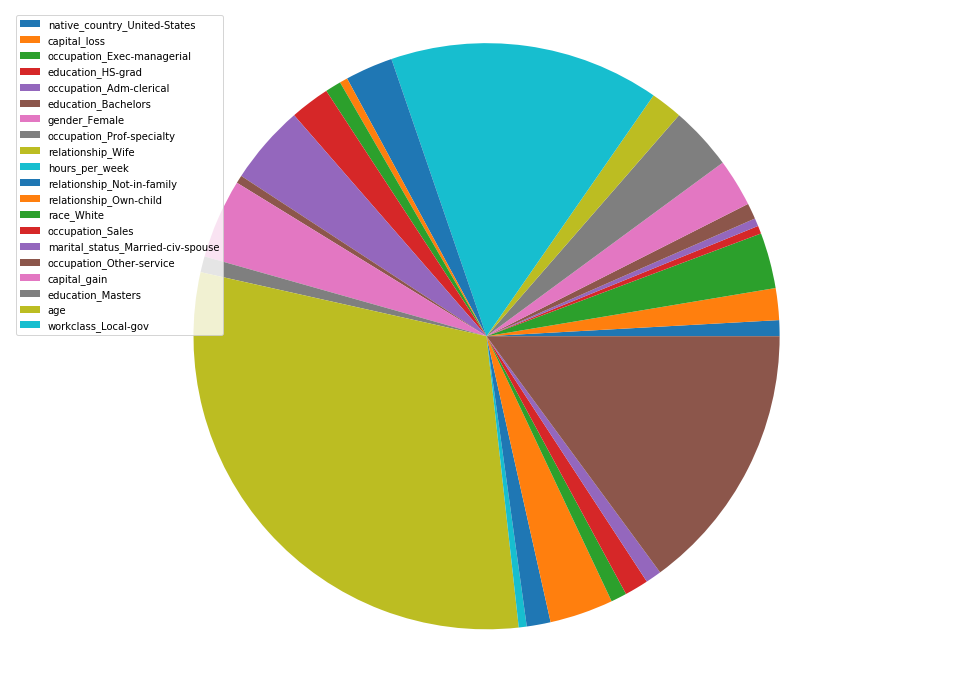

In [450]:
pie_labels = [x for x in bst.get_fscore()]
pie_vals = bst.get_fscore().values()

plt.figure(figsize=(17, 12))
plt.legend(patches, pie_labels, loc=2)
patches, text = plt.pie(pie_vals, radius=2)
pie_fscore = plt.axis('equal')

<Container object of 26 artists>

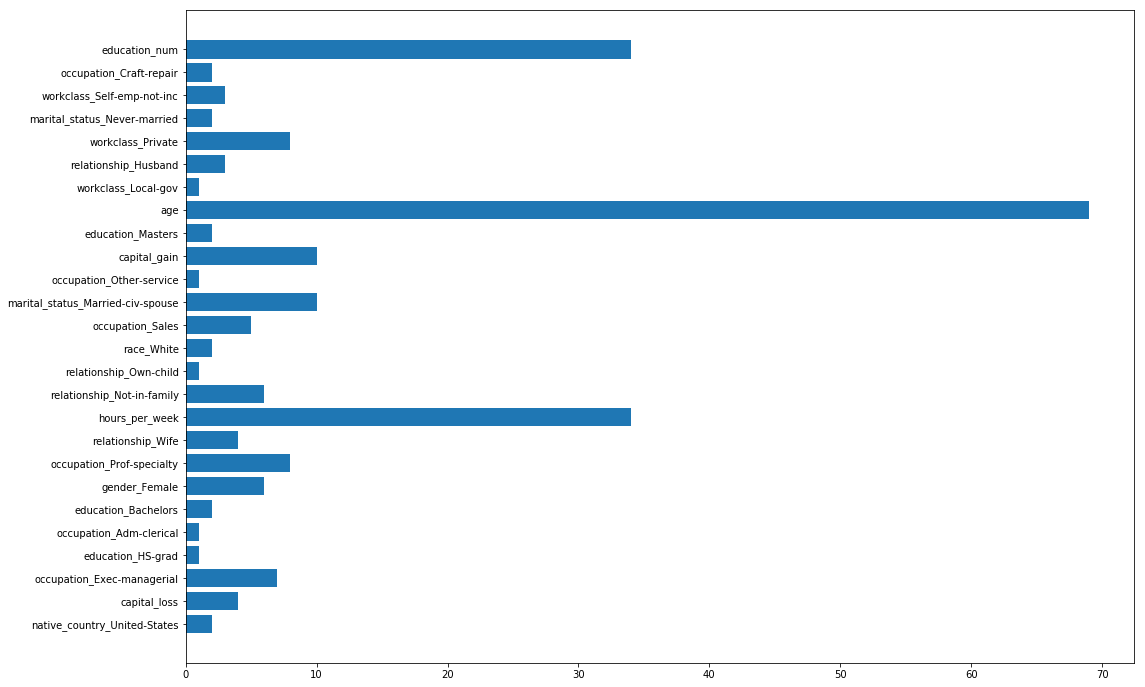

In [451]:
plt.figure(figsize=(17, 12))
ind = np.arange(len(pie_vals))
plt.barh(ind, pie_vals, tick_label=pie_labels)

### Scikit learn interface

In [454]:
X_train, y_train = data_train, df_train[LABEL_COLUMN]
X_test, y_test = data_test, df_test[LABEL_COLUMN]

In [455]:
params = {
    'objective': 'binary:logistic',
    'max_depth': 2,
    'learning_rate': 1.0,
    'silent': 1.0,
    'n_estimators': 5
}

In [456]:
bst2 = XGBClassifier(**params).fit(X_train, y_train)

In [457]:
accuracy_score(y_test, bst2.predict(X_test))

0.85025489834776735

In [458]:
cv = StratifiedKFold(y_train, n_folds=10, shuffle=True, random_state=123)
n_estimators_range = np.linspace(1, 20, 10).astype('int')

train_scores, test_scores = validation_curve(
    XGBClassifier(**params),
    X_train, y_train,
    param_name = 'n_estimators',
    param_range = n_estimators_range,
    cv=cv,
    scoring='accuracy'
)

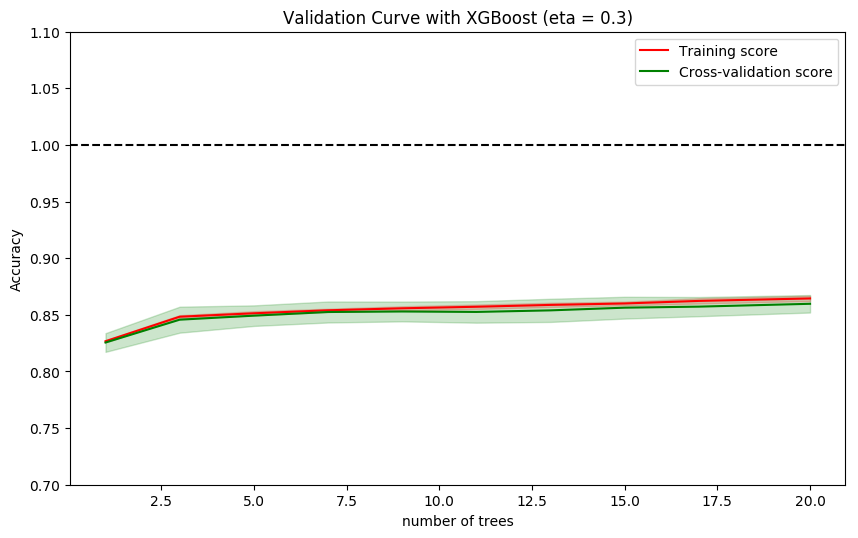

Best cross-validation result (0.86) obtained for 20 trees


In [74]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fig = plt.figure(figsize=(10, 6), dpi=100)

plt.title("Validation Curve with XGBoost (eta = 0.3)")
plt.xlabel("number of trees")
plt.ylabel("Accuracy")
plt.ylim(0.7, 1.1)

plt.plot(n_estimators_range,
             train_scores_mean,
             label="Training score",
             color="r")

plt.plot(n_estimators_range,
             test_scores_mean, 
             label="Cross-validation score",
             color="g")

plt.fill_between(n_estimators_range, 
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, 
                 alpha=0.2, color="r")

plt.fill_between(n_estimators_range,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std,
                 alpha=0.2, color="g")

plt.axhline(y=1, color='k', ls='dashed')

plt.legend(loc="best")
plt.show()

i = np.argmax(test_scores_mean)
print("Best cross-validation result ({0:.2f}) obtained for {1} trees".format(test_scores_mean[i], n_estimators_range[i]))

## Use Grid search to find best hyperparams

In [459]:
params_grid = {
    'max_depth': [2, 3, 5, 8],
    'n_estimators': [10, 25, 50],
    'learning_rate': [0.5, 0.1, 0.05, 0.001], #np.linspace(1e-16, 1, 3)
    'colsample_bytree': [0.3, 0.6],
    'subsample': [0.3, 0.5, 0.7], 
}

params_fixed = {
    'objective': 'binary:logistic',
    'silent': 1
}

In [460]:
bst_grid = GridSearchCV(
    estimator=XGBClassifier(**params_fixed),
    param_grid=params_grid,
    cv=cv,
    scoring='accuracy'
)

In [461]:
bst_grid.fit(X_train, y_train)

GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[0 0 ..., 1 0], n_folds=10, shuffle=True, random_state=123),
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=1, subsample=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 25, 50], 'subsample': [0.3, 0.5, 0.7], 'learning_rate': [0.5, 0.1, 0.05, 0.001], 'colsample_bytree': [0.3, 0.6], 'max_depth': [2, 3, 5, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x116150390>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x119932210>], dtype=object)

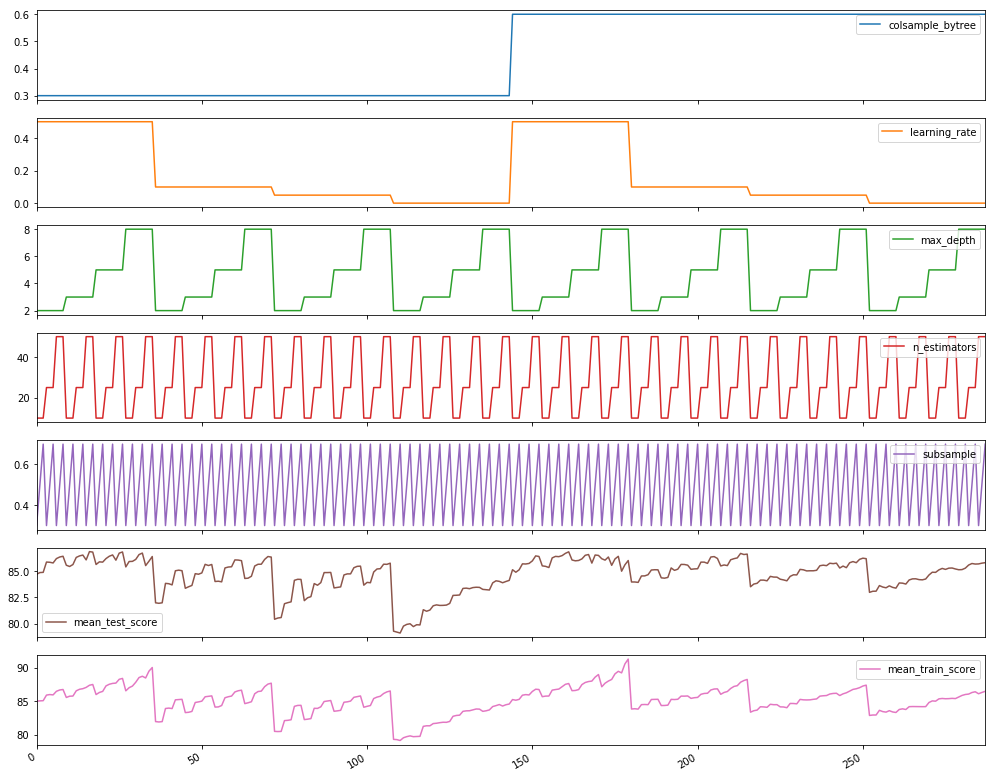

In [464]:
df_bst_grid_params = pd.DataFrame(list(bst_grid.cv_results_['params']))
df_bst_grid_test_score = pd.DataFrame(bst_grid.cv_results_['mean_test_score']*100, columns=['mean_test_score'])
df_bst_grid_train_score = pd.DataFrame(bst_grid.cv_results_['mean_train_score']*100, columns=['mean_train_score'])
df_bst_grid = pd.concat([df_bst_grid_params, df_bst_grid_test_score, df_bst_grid_train_score], axis=1)
df_bst_grid.plot(figsize=(17,15), subplots=True)

In [465]:
print("Best accuracy obtained: {0}".format(bst_grid.best_score_))
print("Parameters:")
for key, value in bst_grid.best_params_.items():
    print("\t{}: {}".format(key, value))

Best accuracy obtained: 0.868525108739
Parameters:
	n_estimators: 50
	subsample: 0.5
	learning_rate: 0.5
	colsample_bytree: 0.3
	max_depth: 3


In [466]:
bst_grid.best_params_

{'colsample_bytree': 0.3,
 'learning_rate': 0.5,
 'max_depth': 3,
 'n_estimators': 50,
 'subsample': 0.5}

In [467]:
confusion_matrix(y_test, bst_grid.best_estimator_.predict(X_test))

array([[11675,   760],
       [ 1569,  2277]])

In [468]:
bst_grid.best_score_, bst_grid.best_params_

(0.86852510873863187,
 {'colsample_bytree': 0.3,
  'learning_rate': 0.5,
  'max_depth': 3,
  'n_estimators': 50,
  'subsample': 0.5})

### Trying to rescale weights and see if that changes accuracy

In [218]:
y_train_summary = Counter(y_train)
y_train_summary.items()

[(0, 11545), (1, 3629)]

In [256]:
weights = np.zeros(len(y_train))
weights[y_train == 0] = 1
weights[y_train == 1] = 1.5

In [252]:
bst_params = params_fixed
bst_params.update(bst_grid.best_params_)
bst_params['silent'] = 0
bst_params

{'colsample_bytree': 0.3,
 'learning_rate': 0.5,
 'max_depth': 3,
 'n_estimators': 50,
 'objective': 'binary:logistic',
 'silent': 0,
 'subsample': 0.5}

In [257]:
dtrain_weighted = xgb.DMatrix(X_train, label=y_train, weight=weights) # weights added

In [258]:
num_rounds = 20
watchlist  = [(dtest,'test'), (dtrain_weighted,'train')]
bst_weighted = xgb.train(bst_params, dtrain_weighted, num_rounds, watchlist)

[0]	test-error:0.184878	train-error:0.233423
[1]	test-error:0.182176	train-error:0.229067
[2]	test-error:0.168786	train-error:0.208259
[3]	test-error:0.168049	train-error:0.207376
[4]	test-error:0.166575	train-error:0.207552
[5]	test-error:0.151219	train-error:0.183742
[6]	test-error:0.151588	train-error:0.183624
[7]	test-error:0.149807	train-error:0.176943
[8]	test-error:0.148394	train-error:0.176207
[9]	test-error:0.150421	train-error:0.176561
[10]	test-error:0.143296	train-error:0.171763
[11]	test-error:0.143173	train-error:0.167525
[12]	test-error:0.141392	train-error:0.165995
[13]	test-error:0.143112	train-error:0.162993
[14]	test-error:0.14047	train-error:0.163581
[15]	test-error:0.140041	train-error:0.162375
[16]	test-error:0.138382	train-error:0.16105
[17]	test-error:0.138444	train-error:0.160609
[18]	test-error:0.137461	train-error:0.161021
[19]	test-error:0.138996	train-error:0.159255


In [265]:
y_pred_weighted = np.round(bst_weighted.predict(dtest))
print(accuracy_score(y_test, y_pred_weighted))
print(precision_score(y_test, y_pred_weighted))
print(recall_score(y_test, y_pred_weighted))

0.861003623856
0.72264416315
0.667966718669


In [262]:
confusion_matrix(y_test, np.round(bst_weighted.predict(dtest)))

array([[11449,   986],
       [ 1277,  2569]])

In [266]:
y_pred_bst = np.round(bst.predict(dtest))
print(accuracy_score(y_test, y_pred_bst))
print(precision_score(y_test, y_pred_bst))
print(recall_score(y_test, y_pred_bst))

0.865855905657
0.762642225032
0.627405096204


In [267]:
confusion_matrix(y_test, y_pred_bst)

array([[11684,   751],
       [ 1433,  2413]])

## Experiment:

Just for fun checking if changing categorical features to IDs instead of to one-hot cols has impact on accuracy

In [422]:
df_train2 = pd.read_csv('train.data', names=COLUMNS, skipinitialspace=True)
df_test2 = pd.read_csv('test.data', names=COLUMNS, skipinitialspace=True, skiprows=1)

# remove NaN elements
df_train2 = df_train.dropna(how='any', axis=0)
df_test2 = df_test.dropna(how='any', axis=0)

df_train2[LABEL_COLUMN] = (
  df_train2["income_bracket"].apply(lambda x: ">50K" in x)).astype(int)
df_test2[LABEL_COLUMN] = (
  df_test2["income_bracket"].apply(lambda x: ">50K" in x)).astype(int)

df_test2.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket,label
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.,0
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.,0
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.,1
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.,1
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.,0


In [473]:
def df_to_indices(df):
    return df.apply(lambda x: pd.factorize(x)[0], axis=0)

def convert_dataframe_to_indices(dataframe, normalize=False):
    df_cat_indices = df_to_indices(dataframe[CATEGORICAL_COLUMNS])
    df_continous_cols = dataframe[CONTINUOUS_COLUMNS]
    if normalize:
        df_continous_cols = normalize_dataframe(df_continous_cols)
    df_indices = pd.concat([df_continous_cols, df_cat_indices], axis=1)
    print("shape: %s" % (df_indices.shape,))
    return df_indices

data_train2 = convert_dataframe_to_indices(df_train2)
data_test2 = convert_dataframe_to_indices(df_test2)

shape: (15174, 13)
shape: (16281, 13)


In [474]:
data_train2.head()

,age,education_num,capital_gain,capital_loss,hours_per_week,workclass,education,marital_status,occupation,relationship,race,gender,native_country
0,39,13,2174.0,0.0,40.0,0,0,0,0,0,0,0,0
1,50,13,0.0,0.0,13.0,1,0,1,1,1,0,0,0
2,38,9,0.0,0.0,40.0,2,1,2,2,0,0,0,0
3,53,7,0.0,0.0,40.0,2,2,1,2,1,1,0,0
4,28,13,0.0,0.0,40.0,2,0,1,3,2,1,1,1


In [475]:
X_train2, y_train2 = data_train2, df_train2[LABEL_COLUMN]
X_test2, y_test2 = data_test2, df_test2[LABEL_COLUMN]

In [ ]:
params = {
    'objective': 'binary:logistic',
    'max_depth': 2,
    'learning_rate': 1.0,
    'silent': 1.0,
    'n_estimators': 5
}

In [476]:
bst_indices = XGBClassifier(**bst_params).fit(X_train2, y_train2)

In [478]:
accuracy_score(y_test2, bst_indices.predict(X_test2))

0.83256556722560038

#### Test result: changing to one-hot (comparing with changing to consecutiev IDs) improves accuracy by 2%

## Summary

Best test set accuracy score is 86.1% using grid search to find best hyperparameters and rescaled weights